In [102]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

## Predict Calorie Expenditure Data set
The dataset is synthetically generated using a deep learning model trained on the real-world Calories Burnt Prediction Dataset. While the overall distribution and structure are aligned with the original dataset, key statistical nuances have been deliberately altered to introduce challenge and prevent overfitting to known solutions.

- *id:*	Unique identifier for each sample in the test dataset. Used for aligning predictions in the submission file.
- *Sex:* Biological sex of the individual. Typically encoded as categorical (e.g., 'male' or 'female'), potentially affecting calorie expenditure due to physiological differences.
- *Age:* Age of the individual (in years). Age influences metabolism and energy consumption.
- *Height:*	Height of the individual (in centimeters). Affects BMI and indirectly influences energy needs.
- *Weight:*	Weight of the individual (in kilograms). A critical factor in determining energy burned during physical activity.
- *Duration:* Duration of physical activity or exercise (in minutes). A direct measure of exercise volume impacting calories burned.
- *Heart_Rate:* Heart rate recorded during the activity (in beats per minute). Reflects intensity of the physical effort.
- *Body_Temp:* Body temperature during the activity (in degrees Celsius). Can indicate metabolic rate or physiological response to exertion.

### Recommended Explorations
- Analyze feature importances to understand drivers of caloric expenditure.
- Compare performance with and without the original dataset as supplemental training data.
- Investigate the model's robustness using cross-validation and adversarial feature perturbation.

In [103]:
#Importar dataset
df_predict_calories = pd.read_csv("C:/Users/THINKBOOK/Documents/1. ESTUDIOS y FORMACIONES/PROGRAMMING/Data Science/Desarrollos de las clases/Clase 20 - Aprendizaje Supervisado - Regresión (parte 2)/train.csv")
df_predict_calories.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.00,82.00,26.00,101.00,41.00,150.00
1,1,female,64,163.00,60.00,8.00,85.00,39.70,34.00
2,2,female,51,161.00,64.00,7.00,84.00,39.80,29.00
3,3,male,20,192.00,90.00,25.00,105.00,40.70,140.00
4,4,female,38,166.00,61.00,25.00,102.00,40.60,146.00


*Nota:* El set de entrenamiento contiene la variable target.

### EDA (Exploratory Data Analysis)

In [104]:
#Explorar la dimensionalidad del dataset
print(f"Shape del dataset de entrenamiento: {df_predict_calories.shape}")

Shape del dataset de entrenamiento: (750000, 9)


In [105]:
#Explorar estructura del dataset
df_predict_calories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [106]:
#Buscar valores nulos
df_predict_calories.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

### Explorando columnas categóricas

In [107]:
#Contar el numero de valores únicos en las columnas categoricas
for col in df_predict_calories.select_dtypes(include=['object']).columns:
    print(col, df_predict_calories[col].nunique())

Sex 2


In [108]:
#Columnas categoricas del dataset
df_predict_calories.select_dtypes(include=[object]).columns

Index(['Sex'], dtype='object')

In [109]:
#Visualizando registros por caracteristica en cada columna categorica
for i in df_predict_calories.select_dtypes(include=[object]).columns:
    print(df_predict_calories[i].value_counts())

Sex
female    375721
male      374279
Name: count, dtype: int64


### Explorando columnas númericas

In [110]:
#Verificando columnas numericas
df_predict_calories.select_dtypes(include=[np.number]).columns

Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')

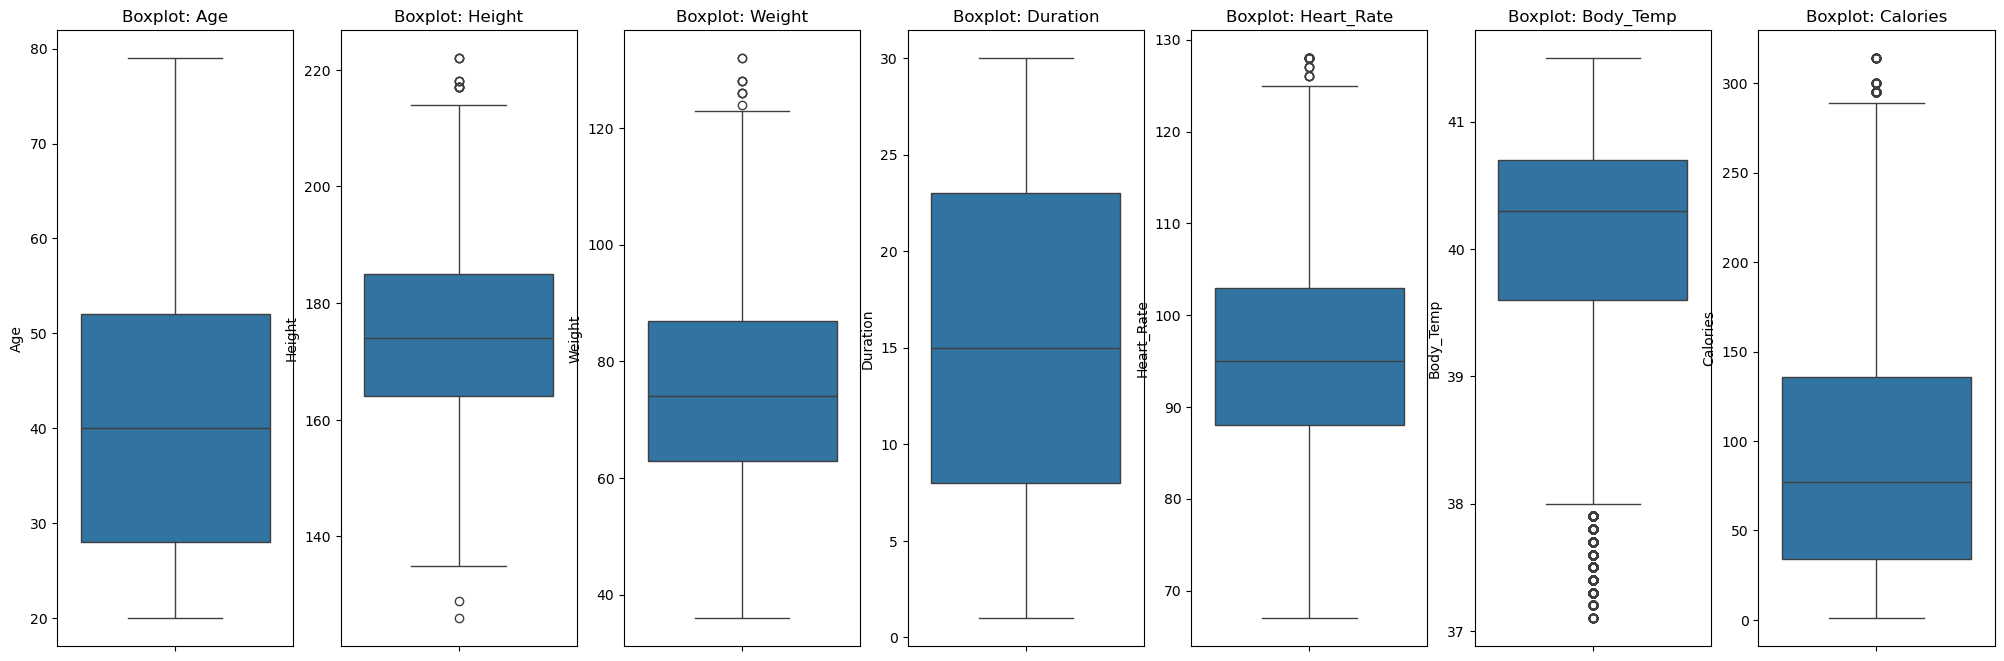

In [111]:
#Boxplot para explorar variables numericas del dataset
numeric_columns=['Age','Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
fig, axs = plt.subplots(1, 7, figsize = (25,8))

for i, ax in enumerate(axs.flatten()):
    if i < len(numeric_columns):
        ax.set_title("Boxplot: " + f'{numeric_columns[i]}')
        sns.boxplot(df_predict_calories[numeric_columns[i]], ax=ax)
    else:
        ax.set_visible(False)

plt.show()

### Análisis de Outliers a Eliminar y Conservar
Para el caso de la eliminación y conservación de los outliers de nuestro dataset, tendremos en cuenta las métricas de evaluación y el objetivo de que el modelo generado sea aplicable a una población promedio.

#### Análisis variable por variable según lo que se visualiza en el boxplot:

*Height*

Se identifican outliers en rangos bajos (126–140 cm) y altos (≈215 cm). Aunque son poco frecuentes, fisiológicamente son posibles, sin embargo orientaremos al modelo de tal manera que realicé sus predicciones teniendo en cuenta población promedio.

In [112]:
# Verificando outliers relacionados a la altura (alturas muy bajas)
df_predict_calories[df_predict_calories['Height'] < 140]

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
9206,9206,female,43,139.00,59.00,20.00,92.00,40.70,99.00
32585,32585,female,28,138.00,41.00,2.00,83.00,38.50,7.00
63975,63975,female,68,137.00,46.00,28.00,114.00,40.90,221.00
127646,127646,female,20,136.00,45.00,1.00,90.00,37.80,5.00
161778,161778,female,39,139.00,43.00,3.00,76.00,38.70,10.00
163849,163849,female,24,138.00,52.00,28.00,109.00,40.90,184.00
201837,201837,female,57,136.00,50.00,26.00,114.00,40.90,196.00
222696,222696,female,41,129.00,41.00,26.00,102.00,40.90,164.00
365409,365409,female,63,139.00,45.00,2.00,81.00,38.50,7.00
374655,374655,female,75,139.00,44.00,25.00,100.00,40.90,165.00


In [113]:
df_predict_calories_clean = df_predict_calories.copy()

#Eliminación de valores demasiado atipicos de altura
df_predict_calories_clean = df_predict_calories.drop(df_predict_calories[df_predict_calories['Height'] > 215].index)
#Eliminación de valores demasiado atipicos de altura
df_predict_calories_clean = df_predict_calories.drop(df_predict_calories[df_predict_calories['Height'] < 142].index)

*Weight*

Outliers en rangos altos (>120 kg).
Los pesos que se visualizan como datos atipicos, son válidos, es decir, pueden existir perfectamente personas con ese peso. Dado que hablamos de gasto calórico es conveniente conservar estos registros. 

*Heart Rate*

Outliers altos (~125).
Un ritmo de 125 bpm en actividad física no es un error, es esperado, los ritmos cardiacos se consideran normales o tipicos en el rango de 40 – 200 bpm por tanto conservaremos estos outliers, que pueden brindar además información útil.

*Body Temp*

Outliers entre 37 y 38 °C. Al realizar actividad fisica es normal tener una temperatura corporal entre 37°c y 38°c, casos extremadamente atipicos serían valores < 35°c y mayores a 42°c, por tanto, conservaremos también estos outliers.

### Explorar correlación entre las variables númericas y la variable target

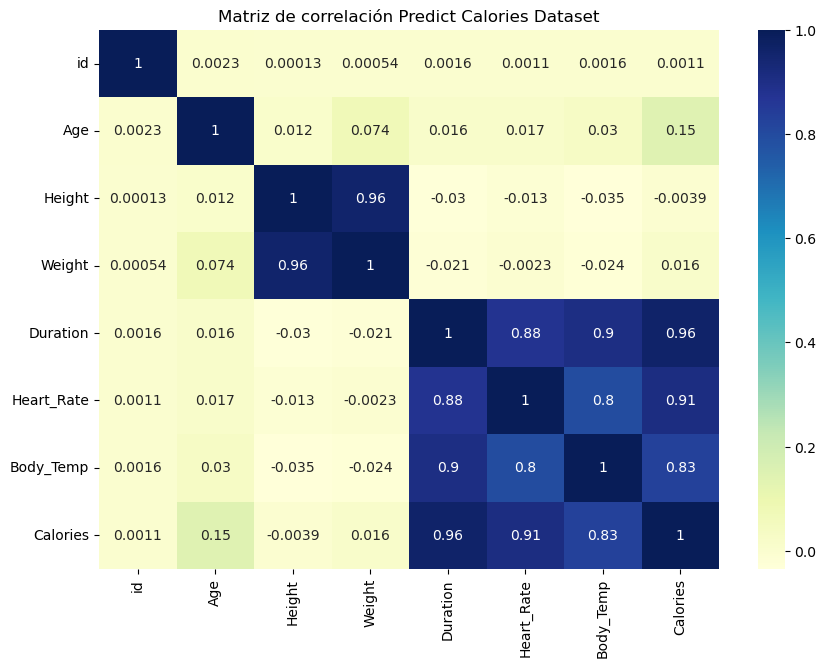

In [114]:
#Matriz de correlación
corr_matrix = df_predict_calories_clean.corr(numeric_only = True)

#Plot correlation heatmap
plt.figure(figsize=(10, 7))  # Ancho: 12 pulgadas, Alto: 8 pulgadas
sns.heatmap(corr_matrix, cmap = "YlGnBu", annot = True, fmt = '.2g')
plt.title('Matriz de correlación Predict Calories Dataset')
plt.show()

A partir de la matriz de correlación de las variables numéricas, observamos que *Duration (0.96)*, *Heart_Rate (0.91)* y *Body_Temp (0.83)* presentan una fuerte asociación lineal con la variable objetivo *Calories*. Esto sugiere que estas tres características tienen un **alto potencial explicativo**, es decir, sus **cambios ayudan a explicar en gran parte las variaciones** sobre el gasto calórico y, por lo tanto, es probable que los modelos de machine learning se apoyen principalmente en ellas para realizar las predicciones. Sin embargo, se debe ser cuidadoso dado que **correlación no implica causalidad** y por tanto no significa que esas variables sean la única causa real de las calorías gastadas.

## Preprocesamiento de datos 

### Aplicar transformación logaritmica a la variable precio

Se aplica transformación logarítmica a la variable *"Calorias"* con el fin de **reducir la asimetría** de su distribución. Esto permite aproximar la variable a una forma más cercana a la **distribución normal**, facilitando el análisis estadístico y la aplicación de modelos que asumen normalidad o linealidad en los datos.

In [115]:
#Aplicar log-transform al precio (evitar log(0) con np.log1p)
df_predict_calories_clean['Log_Calories'] = np.log1p(df_predict_calories_clean['Calories'])

In [116]:
#Antes de la transformacion logaritmica 
print("Asimetría original:", df_predict_calories_clean["Calories"].skew())

#Después de la transformacion logaritmica 
print("Asimetría log-transform:", df_predict_calories_clean["Log_Calories"].skew())

Asimetría original: 0.5393096196616873
Asimetría log-transform: -0.8569906985303862


<Axes: xlabel='Calories', ylabel='Count'>

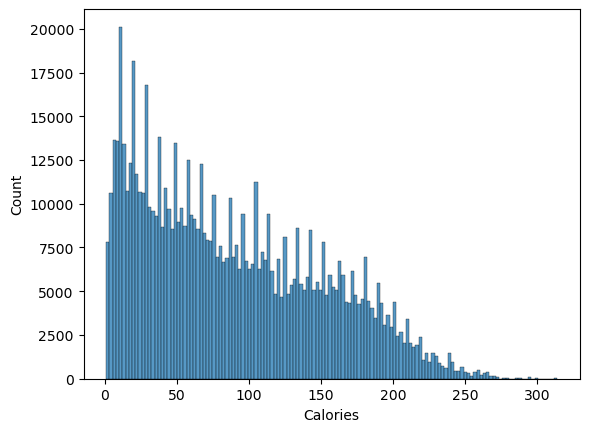

In [117]:
#Visualización de la distribución de la columna 'Price' antes de la transformación log
sns.histplot(df_predict_calories_clean['Calories'])

<Axes: xlabel='Log_Calories', ylabel='Count'>

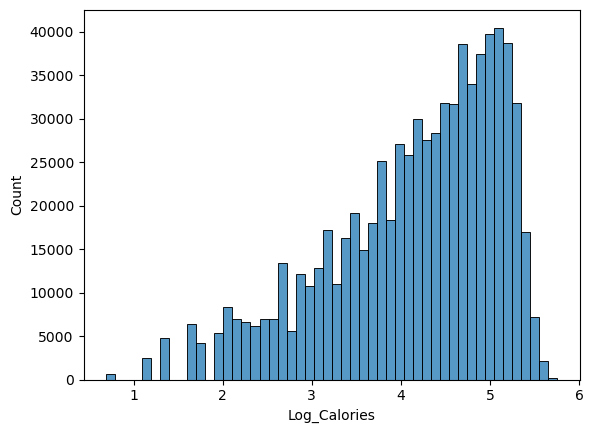

In [118]:
#Visualización de la distribución de la columna 'Calories' después de la transformación log
sns.histplot(df_predict_calories_clean['Log_Calories'], bins = 50)

Observamos que la distribuación obtenida después de aplicar la transformación logaritmica no es la ideal, esta se encuentra ladeada hacia la derecha, por tanto, procederemos a realizar la evalución del modelo con la distribución original de los datos.

In [119]:
df_predict_calories_clean.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Log_Calories
0,0,male,36,189.00,82.00,26.00,101.00,41.00,150.00,5.02
1,1,female,64,163.00,60.00,8.00,85.00,39.70,34.00,3.56
2,2,female,51,161.00,64.00,7.00,84.00,39.80,29.00,3.40
3,3,male,20,192.00,90.00,25.00,105.00,40.70,140.00,4.95
4,4,female,38,166.00,61.00,25.00,102.00,40.60,146.00,4.99


#### Aplicar OneHotEncoding a la variable categorica 'Sexo'

Transformamos la única variable categorica del dataset 'Sexo' en variable númerica implementando OneHotEncoding.

In [120]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

#"Ajusta" el OneHotEncoder a las columnas categóricas
encoder.fit(df_predict_calories_clean[df_predict_calories_clean.select_dtypes(include=['object']).columns])

#Aplica la transformación One Hot Encoding a las columnas categoricas (se obtiene una matriz dispersa)
encoded_data = encoder.transform(df_predict_calories_clean[df_predict_calories_clean.select_dtypes(include=['object']).columns]).toarray()

print(f"Características númericas y categoricas originales: {encoder.categories_}")
#recuperar los nombres de las columnas resultantes del OneHotEncoder
print(f"Características categoricas después del OneHotEncoder: {encoder.get_feature_names_out()}")

#obtener en un df los nombres de las nuevas columnas codificadas
df_predict_calories_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

#Unificar las categoricas con las numericas por el index
df_predict_calories_preprocesado = df_predict_calories_encoded.merge(df_predict_calories_clean.select_dtypes(include=[np.number]),
                                                      left_index=True, right_index=True)
df_predict_calories_preprocesado

Características númericas y categoricas originales: [array(['female', 'male'], dtype=object)]
Características categoricas después del OneHotEncoder: ['Sex_female' 'Sex_male']


,Sex_female,Sex_male,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Log_Calories
0,0.00,1.00,0,36,189.00,82.00,26.00,101.00,41.00,150.00,5.02
1,1.00,0.00,1,64,163.00,60.00,8.00,85.00,39.70,34.00,3.56
2,1.00,0.00,2,51,161.00,64.00,7.00,84.00,39.80,29.00,3.40
3,0.00,1.00,3,20,192.00,90.00,25.00,105.00,40.70,140.00,4.95
4,1.00,0.00,4,38,166.00,61.00,25.00,102.00,40.60,146.00,4.99
...,...,...,...,...,...,...,...,...,...,...,...
749901,0.00,1.00,749901,40,161.00,65.00,13.00,95.00,40.20,64.00,4.17
749902,1.00,0.00,749902,40,169.00,74.00,8.00,83.00,39.90,29.00,3.40
749903,0.00,1.00,749903,45,174.00,78.00,4.00,86.00,39.00,15.00,2.77
749904,0.00,1.00,749904,49,187.00,85.00,26.00,101.00,40.70,160.00,5.08


#### Estandarización de los datos

In [121]:
#Escalar los datos de las diferentes columnas
scaler = StandardScaler()
df_predict_calories_escalado = scaler.fit_transform(df_predict_calories_preprocesado.drop(columns = ['Calories','Log_Calories'], axis = 1))
pd.DataFrame(df_predict_calories_escalado, columns = df_predict_calories_preprocesado.drop(columns = ['Calories','Log_Calories'], axis = 1).columns)

,Sex_female,Sex_male,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,-1.00,1.00,-1.73,-0.36,1.12,0.49,1.27,0.58,1.24
1,1.00,-1.00,-1.73,1.49,-0.91,-1.08,-0.89,-1.11,-0.43
2,1.00,-1.00,-1.73,0.63,-1.07,-0.80,-1.01,-1.22,-0.30
3,-1.00,1.00,-1.73,-1.41,1.35,1.06,1.15,1.01,0.85
4,1.00,-1.00,-1.73,-0.23,-0.68,-1.01,1.15,0.69,0.72
...,...,...,...,...,...,...,...,...,...
749807,-1.00,1.00,1.73,-0.09,-1.07,-0.73,-0.29,-0.05,0.21
749808,1.00,-1.00,1.73,-0.09,-0.44,-0.08,-0.89,-1.32,-0.17
749809,-1.00,1.00,1.73,0.24,-0.05,0.20,-1.37,-1.00,-1.33
749810,-1.00,1.00,1.73,0.50,0.96,0.70,1.27,0.58,0.85


## Entrenamiento y evaluación 

#### 1. Separar los datos de entrenamiento y prueba

In [122]:
from sklearn.model_selection import train_test_split

X = df_predict_calories_escalado
y = df_predict_calories_preprocesado['Calories']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

#### 2. Seleccionar los modelos a usar

Para este ejercicio por la cantidad de registros que se tienen y para evitar problemas de ineficiencia en la memoria, se evaluarán los modelos seleccionados por individual, las métricas de los mismos se guardarán en un documento excel, para posteriormente verlas todas en conjunto y observar el modelo con mejor rendimiento. Los modelos elegidos son:

- Decision Tree Regressor
- RandomForestRegressor
- Linear Regression

#### 3. Entrenar, Realizar predicción y Evaluar los modelos seleccionados

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

**Decision Tree Regression**

In [82]:
#Instanciar los modelos y configurar sus hiperparametros
model_DT = DecisionTreeRegressor(random_state=42)

# Entrenamiento y predicción
model_DT.fit(X_train, y_train)
y_pred_DT = model_DT.predict(X_test)

# Guardar métricas en un diccionario
metricas_DT = {
    "Modelo": "DecisionTreeRegressor",
    "MSE": mean_squared_error(y_test, y_pred_DT),
    "MAE": mean_absolute_error(y_test, y_pred_DT),
    "R2": r2_score(y_test, y_pred_DT)
}

# Guardar métricas y que persistan en varias corridas,a través de un DataFrame
import pandas as pd

try:
    df_metricas = pd.read_csv("metricas.csv")  # Si ya existe, lo cargamos
except FileNotFoundError:
    df_metricas = pd.DataFrame(columns=["Modelo","MSE","MAE","R2"])

# Agregar la nueva fila
df_metricas = pd.concat([df_metricas, pd.DataFrame([metricas_DT])], ignore_index=True)

# Guardar en CSV para persistencia
df_metricas.to_csv("metricas.csv", index=False)

# --- Eliminar modelo y predicciones de memoria ---
del model_DT

**Random Forest Regressor**

In [124]:
#Instanciar los modelos y configurar sus hiperparametros
model_RF = RandomForestRegressor(random_state=42,  max_features="sqrt",max_depth=20, min_samples_split=5, n_estimators=600, n_jobs=-1)

# Entrenamiento y predicción
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

# Guardar métricas en un diccionario
metricas_RF = {
    "Modelo": "RandomForestRegressor",
    "MSE": mean_squared_error(y_test, y_pred_RF),
    "MAE": mean_absolute_error(y_test, y_pred_RF),
    "R2": r2_score(y_test, y_pred_RF)
}

# Guardar métricas y que persistan en varias corridas,a través de un DataFrame
import pandas as pd

try:
    df_metricas = pd.read_csv("metricas.csv")  # Si ya existe, lo cargamos
except FileNotFoundError:
    df_metricas = pd.DataFrame(columns=["Modelo","MSE","MAE","R2"])

# Agregar la nueva fila
df_metricas = pd.concat([df_metricas, pd.DataFrame([metricas_RF])], ignore_index=True)

# Guardar en CSV para persistencia
df_metricas.to_csv("metricas.csv", index=False)

# --- Eliminar modelo y predicciones de memoria ---
del model_RF

**Linear Regression**

In [84]:
#Instanciar los modelos y configurar sus hiperparametros
model_Linear = LinearRegression(n_jobs=None)

# Entrenamiento y predicción
model_Linear.fit(X_train, y_train)
y_pred_Linear = model_Linear.predict(X_test)

# Guardar métricas en un diccionario
metricas_Linear = {
    "Modelo": "Linear Regression",
    "MSE": mean_squared_error(y_test, y_pred_Linear),
    "MAE": mean_absolute_error(y_test, y_pred_Linear),
    "R2": r2_score(y_test, y_pred_Linear)
}

# Guardar métricas y que persistan en varias corridas,a través de un DataFrame
import pandas as pd

try:
    df_metricas = pd.read_csv("metricas.csv")  # Si ya existe, lo cargamos
except FileNotFoundError:
    df_metricas = pd.DataFrame(columns=["Modelo","MSE","MAE","R2"])

# Agregar la nueva fila
df_metricas = pd.concat([df_metricas, pd.DataFrame([metricas_Linear])], ignore_index=True)

# Guardar en CSV para persistencia
df_metricas.to_csv("metricas.csv", index=False)

# --- Eliminar modelo y predicciones de memoria ---
del model_Linear

## Comparación de Modelos

In [89]:
#Eliminar filas 
df_metricas= df_metricas.drop(index=[3,4,5,6,7,8,9])
df_metricas.reset_index(drop=True, inplace=True)

In [97]:
#Dataframe de métricas de evaluación
pd.options.display.float_format = "{:.3f}".format
print(df_metricas.sort_values(by='R2', ascending = False)) #imprimir métricas y ordenarlas por mejores modelos 

                  Modelo     MSE   MAE    R2
1  RandomForestRegressor  18.644 2.526 0.995
2  DecisionTreeRegressor  37.313 3.600 0.990
0      Linear Regression 123.841 8.110 0.968


A partir de la evaluación de los 3 modelos empleados para la predicción de la variable target, en este caso *'Calories'*, se observan métricas con valores favorables para todas, esto se ve representado por un R2 > 0.95. El modelo con mejor rendimiento resulta ser **Random Forest Regressor** con un resultado de R2 cercano a 1, además de valores de MSE y MAE bajos.

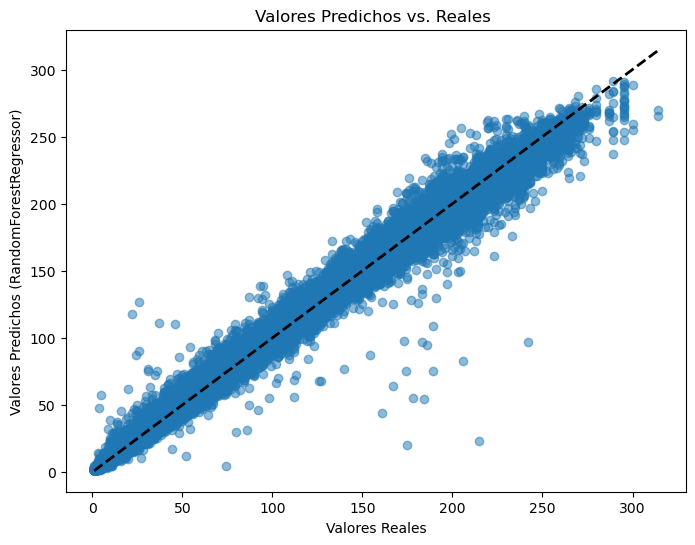

In [100]:
import matplotlib.pyplot as plt
# Realizar predicciones con el modelo con mejor resultado

# Crear un gráfico de dispersión de valores predichos vs. reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RF, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos (RandomForestRegressor)')
plt.title('Valores Predichos vs. Reales ')

# Dibujar una línea digonal de referencia (línea y=x de identidad) - línea perfecta de predicción:
plt.plot([y_test.min(), y_test.max()], # X (límites mínimo y máximo de y_test)
         [y_test.min(), y_test.max()], # Y (límites mínimo y máximo de y_test)
         'k--', lw=2                   # línea negra discontinua 'k--' y grosor de la linea 'lw'
) 
plt.show()

En la gráfica se observa que el modelo **RandomForestRegressor** captura con buena precisión los patrones presentes en los datos, ya que la mayoría de los puntos se distribuyen alrededor de la línea de identidad (y = x), lo cual refleja una adecuada capacidad predictiva. Sin embargo, también se aprecia que varias predicciones se concentran por debajo de la línea de identidad, lo que indica que el modelo tiende a **subestimar el gasto calórico en ciertos casos.**

Este comportamiento puede explicarse porque en el conjunto de datos existe una mayor proporción de registros con **valores bajos de gasto calórico**, lo que sesga el aprendizaje del modelo hacia esa zona y reduce su capacidad de generalización en rangos más altos.

## Conclusiones 

Se evaluaron tres modelos de predicción: **Linear Regression, Decision Trees y Random Forest**. Entre ellos, el modelo de **RandomForestRegressor** se destacó ampliamente, alcanzando una métrica de desempeño de **R² ≈ 0.995**, lo cual se refleja en la alta densidad de puntos alrededor de la línea de predicción perfecta (y=x). Este resultado evidencia que el modelo logró capturar con gran precisión los patrones de los datos, generando predicciones muy cercanas a los valores reales.

Si bien se consideraron otros algoritmos más complejos como **XGBoost** o variantes de boosting, el alto volumen de registros hace que su implementación sea más costosa en términos de memoria y tiempo de cómputo. Por ello, Random Forest representa una solución robusta y eficiente frente a la complejidad de los datos analizados.

En conclusión, se cumplió con el objetivo planteado: **obtener un modelo capaz de predecir el gasto calórico con precisión y métricas sobresalientes**, confirmando la utilidad del enfoque adoptado y validando la pertinencia de las variables consideradas.